<a href="https://colab.research.google.com/github/deepthivj-aiml/Video-Anomaly-Detection/blob/main/Video_Anomaly_Detection_in_Streaming_Content.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Video downloaded: /content/sample_video.mp4
Processed frames: torch.Size([300, 1024])
Autoencoder trained.


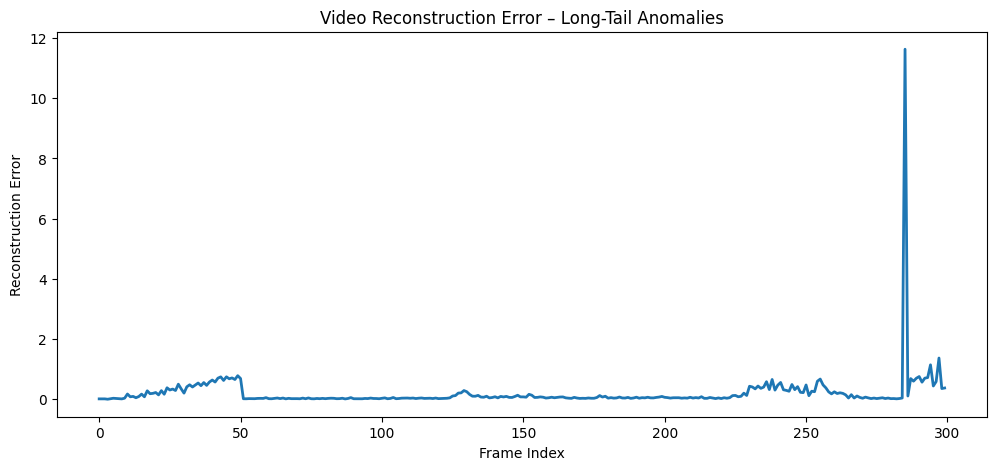

Frames in anomaly tail: 3


In [2]:
# Single-cell Video Anomaly Detection (PUBLIC DOMAIN VIDEO)
!pip install --quiet opencv-python torch torchvision numpy matplotlib

import cv2
import numpy as np
import torch
import torch.nn as nn
import matplotlib.pyplot as plt
import urllib.request
import os

# -----------------------------
# Step 1: Download Public-Domain Video (Reliable)
# -----------------------------
video_url = "https://commondatastorage.googleapis.com/gtv-videos-bucket/sample/BigBuckBunny.mp4"
video_path = "/content/sample_video.mp4"

if not os.path.exists(video_path):
    urllib.request.urlretrieve(video_url, video_path)

print("Video downloaded:", video_path)

# -----------------------------
# Step 2: Read Video & Extract Motion Features
# -----------------------------
cap = cv2.VideoCapture(video_path)
frames = []

ret, prev = cap.read()
prev = cv2.cvtColor(prev, cv2.COLOR_BGR2GRAY)

frame_count = 0
while frame_count < 300:  # limit for speed
    ret, frame = cap.read()
    if not ret:
        break
    gray = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
    diff = cv2.absdiff(gray, prev)
    frames.append(diff.flatten()[:1024])  # compact motion vector
    prev = gray
    frame_count += 1

cap.release()

X = np.array(frames)
X = (X - X.mean()) / (X.std() + 1e-6)
X_tensor = torch.tensor(X, dtype=torch.float32)

print("Processed frames:", X_tensor.shape)

# -----------------------------
# Step 3: Autoencoder for Video Anomaly Detection
# -----------------------------
class VideoAE(nn.Module):
    def __init__(self):
        super().__init__()
        self.encoder = nn.Sequential(
            nn.Linear(1024, 256), nn.ReLU(),
            nn.Linear(256, 64)
        )
        self.decoder = nn.Sequential(
            nn.Linear(64, 256), nn.ReLU(),
            nn.Linear(256, 1024)
        )

    def forward(self, x):
        return self.decoder(self.encoder(x))

model = VideoAE()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
loss_fn = nn.MSELoss()

for epoch in range(15):
    optimizer.zero_grad()
    loss = loss_fn(model(X_tensor), X_tensor)
    loss.backward()
    optimizer.step()

print("Autoencoder trained.")

# -----------------------------
# Step 4: Reconstruction Error (Anomaly Signal)
# -----------------------------
with torch.no_grad():
    recon = model(X_tensor)
    recon_error = torch.mean((recon - X_tensor)**2, dim=1).numpy()

# -----------------------------
# Step 5: Long-Tail Visualization
# -----------------------------
plt.figure(figsize=(12,5))
plt.plot(recon_error, linewidth=2)
plt.title("Video Reconstruction Error – Long-Tail Anomalies")
plt.xlabel("Frame Index")
plt.ylabel("Reconstruction Error")
plt.show()

threshold = np.percentile(recon_error, 99)
print("Frames in anomaly tail:", np.sum(recon_error > threshold))
